In [1]:
import sys
sys.path.append('..')
import os
from dotenv import load_dotenv
load_dotenv()

True

# Text Classification

## Dataset

In [2]:
import json

with open("../data/raw/sarcasm/samples.jsonl", "r") as f:
    data = [json.loads(item) for item in list(f)]
    

In [3]:
data[0]

{'input': [{'role': 'system',
   'content': "Respond with only a 1 or 0 to signify if the user's message includes sarcasm, or not"},
  {'role': 'user',
   'content': 'thirtysomething scientists unveil doomsday clock of hair loss'}],
 'ideal': '1'}

In [4]:
data[1]

{'input': [{'role': 'system',
   'content': "Respond with only a 1 or 0 to signify if the user's message includes sarcasm, or not"},
  {'role': 'user',
   'content': 'dem rep. totally nails why congress is falling short on gender, racial equality'}],
 'ideal': '0'}

In [5]:
import random
seed = 42
n_samples = 1000
random.seed(seed)
sample_list = random.choices(data, k=n_samples)


In [6]:
f"Number of sarcasm samples: {len([c for c in sample_list if c['ideal'] == '1'])}"

'Number of sarcasm samples: 457'

In [7]:
f"Number of not sarcasm samples: {len([c for c in sample_list if c['ideal'] == '0'])}"

'Number of not sarcasm samples: 543'

## Non Guided Generation

In [27]:
openai_models = ['gpt-3.5-turbo', 'gpt-4-1106-preview', 'gpt-4']

In [282]:
from openai import OpenAI

client = OpenAI()

def generate_response(sample: dict, model: str):
    response = client.chat.completions.create(
        model=model,
        messages=sample['input'],
        temperature=0.0
    )
    response_message = response.choices[0].message.content
    response_cost =  openai_api_calculate_cost(response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

def openai_api_calculate_cost(usage, model):
    pricing = {
        'gpt-3.5-turbo': {
            'prompt': 0.001,
            'completion': 0.002,
        },
        'gpt-4-1106-preview': {
            'prompt': 0.01,
            'completion': 0.03,
        },
        'gpt-4': {
            'prompt': 0.03,
            'completion': 0.06,
        },
    }

    try:
        model_pricing = pricing[model]
    except KeyError:
        raise ValueError("Invalid model specified")

    prompt_cost = usage.prompt_tokens * model_pricing['prompt'] / 1000
    completion_cost = usage.completion_tokens * model_pricing['completion'] / 1000

    total_cost = prompt_cost + completion_cost


    return total_cost


In [283]:
generate_response(sample = data[0], model="gpt-3.5-turbo")

{'response': '0', 'cost': 4.8e-05}

In [284]:
generate_response(sample = data[0], model="gpt-4-1106-preview")

{'response': '1', 'cost': 0.00049}

In [285]:
for model in openai_models:
    for sample in sample_list:
        sample[model] = generate_response(sample, model)

In [286]:
for model in openai_models:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for gpt-3.5-turbo: 0.546
Cost for gpt-3.5-turbo: 0.047959000000000106
Accuracy for gpt-4-1106-preview: 0.761
Cost for gpt-4-1106-preview: 0.4895900000000002
Accuracy for gpt-4: 0.74
Cost for gpt-4: 1.4387700000000005


## Instructor

In [287]:
import enum
from pydantic import BaseModel

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "sarcasm"
    NOT_SARCASM = "not_sarcasm"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [288]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def classify(sentence: str, model: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model=model,
        response_model=SinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
    )

    response_message = '1' if response.class_label == Labels.SARCASM else '0'
    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

In [289]:
classify(data[0]['input'][1]['content'], 'gpt-3.5-turbo')

{'response': '1', 'cost': 0.000115}

In [290]:
for model in openai_models:
    for sample in sample_list:
        sentence = sample['input'][1]['content']
        sample[f'instructor_{model}'] = classify(sentence, model)

In [291]:
for model in [f'instructor_{model}' for model in openai_models]:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_gpt-3.5-turbo: 0.641
Cost for instructor_gpt-3.5-turbo: 0.11581599999999999
Accuracy for instructor_gpt-4-1106-preview: 0.741
Cost for instructor_gpt-4-1106-preview: 1.2299999999999995
Accuracy for instructor_gpt-4: 0.819
Cost for instructor_gpt-4: 3.4754400000000034


## Instructor (Replication)

In [292]:
import enum
from pydantic import BaseModel

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "1"
    NOT_SARCASM = "0"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [293]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def generate_classification(sample: dict, model: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model=model,
        response_model=SinglePrediction,
        temperature=0.0,
        messages=sample['input'],
    )

    response_message = '1' if response.class_label == Labels.SARCASM else '0'
    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

In [294]:
generate_classification(data[0], 'gpt-3.5-turbo')

{'response': '1', 'cost': 0.000123}

In [295]:
for model in openai_models:
    for sample in sample_list:
        sample[f'instructor_base_{model}'] = generate_classification(sample, model)

In [296]:
for model in [f'instructor_base_{model}' for model in openai_models]:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_base_gpt-3.5-turbo: 0.661
Cost for instructor_base_gpt-3.5-turbo: 0.12295899999999953
Accuracy for instructor_base_gpt-4-1106-preview: 0.767
Cost for instructor_base_gpt-4-1106-preview: 1.2795899999999982
Accuracy for instructor_base_gpt-4: 0.79
Cost for instructor_base_gpt-4: 3.628050000000001


## Instructor (Mixing)

In [297]:
import enum
from pydantic import BaseModel

class NewLabels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    CLEARLY_SARCASM = "clearly_sarcasm"
    CLEARLY_NOT_SARCASM = "clearly_not_sarcasm"
    MAYBE_SARCASM = "maybe_sarcasm"
    MAYBE_NOT_SARCASM = "maybe_not_sarcasm"

class NewSinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: NewLabels

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "sarcasm"
    NOT_SARCASM = "not_sarcasm"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [298]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def classify_mix(sentence: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        response_model=NewSinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
    )

    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model="gpt-3.5-turbo")

    if response.class_label in [NewLabels.CLEARLY_SARCASM, NewLabels.CLEARLY_NOT_SARCASM]:
        response_message = '1' if response.class_label == NewLabels.CLEARLY_SARCASM else '0'
        return {'response': response_message, 'cost': response_cost}
    
    else:
        second_response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=SinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
        )

        response_message = '1' if second_response.class_label == Labels.SARCASM else '0'
        response_cost +=  openai_api_calculate_cost(second_response._raw_response.usage, model="gpt-4-1106-preview")

        return {'response': response_message, 'cost': response_cost} 

In [299]:
classify_mix(data[0]['input'][1]['content'])

{'response': '1', 'cost': 0.0013579999999999998}

In [300]:
for sample in sample_list:
    sentence = sample['input'][1]['content']
    sample[f'instructor_mixing'] = classify_mix(sentence)

In [301]:
model = 'instructor_mixing'
print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_mixing: 0.714
Cost for instructor_mixing: 1.129674


## Results

In [314]:
import pandas as pd

model_labels = ['gpt-3.5-turbo', 'gpt-4-1106-preview', 'gpt-4',
                'instructor_gpt-3.5-turbo', 'instructor_gpt-4-1106-preview', 'instructor_gpt-4',
                'instructor_base_gpt-3.5-turbo', 'instructor_base_gpt-4-1106-preview', 'instructor_base_gpt-4',
                'instructor_mixing']

guide_labels = ['unguided', 'unguided', 'unguided',
                'guided', 'guided', 'guided',
                'guided', 'guided', 'guided',
                'guided']

llm_labels = ['gpt-3.5', 'gpt-4', 'gpt-4',
              'gpt-3.5', 'gpt-4', 'gpt-4',
              'gpt-3.5', 'gpt-4', 'gpt-4',
              'mix']

accuracy = []
cost = []
for model in model_labels:
    accuracy.append(sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list))
    cost.append(sum([item[model]['cost'] for item in sample_list]))

df = pd.DataFrame({'model': model_labels, 'accuracy': accuracy, 'cost': cost, 'guide': guide_labels, 'llm': llm_labels})


In [315]:
df

,model,accuracy,cost,guide,llm
0,gpt-3.5-turbo,0.546,0.047959,unguided,gpt-3.5
1,gpt-4-1106-preview,0.761,0.489590,unguided,gpt-4
2,gpt-4,0.740,1.438770,unguided,gpt-4
3,instructor_gpt-3.5-turbo,0.641,0.115816,guided,gpt-3.5
4,instructor_gpt-4-1106-preview,0.741,1.230000,guided,gpt-4
5,instructor_gpt-4,0.819,3.475440,guided,gpt-4
6,instructor_base_gpt-3.5-turbo,0.661,0.122959,guided,gpt-3.5
7,instructor_base_gpt-4-1106-preview,0.767,1.279590,guided,gpt-4
8,instructor_base_gpt-4,0.790,3.628050,guided,gpt-4
9,instructor_mixing,0.714,1.129674,guided,mix


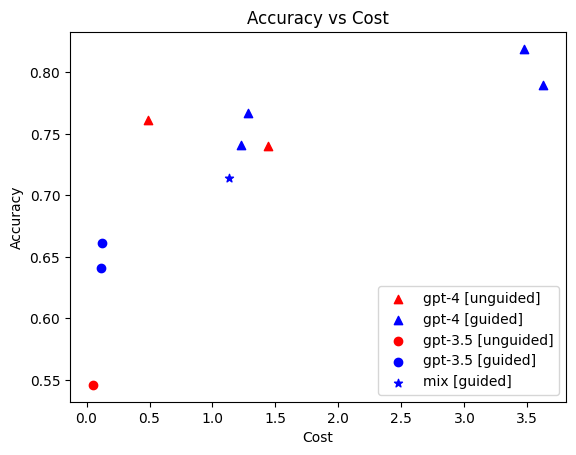

In [321]:
#plot accuracy vs cost
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.scatter(df[(df['llm'] == 'gpt-4')&(df['guide'] == 'unguided')]['cost'],
           df[(df['llm'] == 'gpt-4')&(df['guide'] == 'unguided')]['accuracy'], 
           marker='^', c='red', label='gpt-4 [unguided]')
ax.scatter(df[(df['llm'] == 'gpt-4')&(df['guide'] == 'guided')]['cost'],
           df[(df['llm'] == 'gpt-4')&(df['guide'] == 'guided')]['accuracy'], 
           marker='^', c='blue', label='gpt-4 [guided]')
ax.scatter(df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'unguided')]['cost'],
           df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'unguided')]['accuracy'], 
           marker='o', c='red', label='gpt-3.5 [unguided]')
ax.scatter(df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'guided')]['cost'],
           df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'guided')]['accuracy'], 
           marker='o', c='blue', label='gpt-3.5 [guided]')
ax.scatter(df[df['llm'] == 'mix']['cost'],
           df[df['llm'] == 'mix']['accuracy'], 
           marker='*', c='blue', label='mix [guided]')

plt.legend()

plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Cost')
plt.show()

In [322]:
fig.savefig('../reports/figures/sarcasm_accuracy_vs_cost.png', dpi=300, bbox_inches='tight')

In [304]:
# sample_list to file
with open(f"../data/processed/sarcasm/openai_responses_s_{seed}_n_{n_samples}.jsonl", "w") as f:
    for item in sample_list:
        f.write(json.dumps(item) + "\n")

In [305]:
f'Total Cost: {sum(cost)}'

'Total Cost: 12.957848000000004'

## Mistral

In [8]:
mistral_models =['mistral-tiny', 'mistral-small', 'mistral-medium']

In [41]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

api_key = os.environ["MISTRAL_API_KEY"]
client = MistralClient(api_key=api_key)

def generate_mistral_response(sample: dict, model: str):
    response = client.chat(
        model=model,
        messages=[ChatMessage(role=m['role'], content=m['content']) for m in sample['input']],
        temperature=0.0,
        max_tokens=2
    )
    response_message = response.choices[0].message.content
    response_cost =  mistral_api_calculate_cost(response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

def mistral_api_calculate_cost(usage, model):
    pricing = {
        'mistral-tiny': {
            'prompt': 0.14,
            'completion': 0.42,
        },
        'mistral-small': {
            'prompt': 0.6,
            'completion': 1.8,
        },
        'mistral-medium': {
            'prompt': 2.5,
            'completion': 7.5,
        },
    }

    try:
        model_pricing = pricing[model]
    except KeyError:
        raise ValueError("Invalid model specified")

    prompt_cost = usage.prompt_tokens * model_pricing['prompt'] / 1000000
    completion_cost = usage.completion_tokens * model_pricing['completion'] / 1000000

    total_cost = prompt_cost + completion_cost


    return total_cost

In [42]:
generate_mistral_response(sample = data[0], model="mistral-medium")

{'response': '0\n\nI don\'t have enough context to determine if this statement is sarcastic or not, but based on the information provided, it does not appear to be sarcastic. The use of the word "doomsday" could potentially be interpreted as sarcastic, but without more context it is difficult to say for certain. In general, sarcasm often involves saying the opposite of what is meant or using irony to convey a message, and I do not see evidence of that in this statement. Therefore, I will respond with a 0 to indicate that I do not believe this statement is sarcastic. However, please note that sarcasm can be difficult to detect in text, and my response is based on my best judgment given the information provided.',
 'cost': 0.0013299999999999998}

In [21]:
for model in mistral_models:
    for sample in sample_list:
        sample[model] = generate_mistral_response(sample, model)

In [22]:
# sample_list to file
with open(f"../data/processed/sarcasm/mistral_responses_s_{seed}_n_{n_samples}.jsonl", "w") as f:
    for item in sample_list:
        f.write(json.dumps(item) + "\n")

## Results

In [28]:
sample_list_openai = []
with open(f"../data/processed/sarcasm/openai_responses_s_{seed}_n_{n_samples}.jsonl", "r") as f:
    for line in f:
        sample_list_openai.append(json.loads(line))

sample_list_mistral = []
with open(f"../data/processed/sarcasm/mistral_responses_s_{seed}_n_{n_samples}.jsonl", "r") as f:
    for line in f:
        sample_list_mistral.append(json.loads(line))

In [30]:
sample_list_openai

[{'input': [{'role': 'system',
    'content': "Respond with only a 1 or 0 to signify if the user's message includes sarcasm, or not"},
   {'role': 'user',
    'content': "dozens of white houses materialize from temporal vortex as trump's changing account of putin meeting tears apart space-time"}],
  'ideal': '1',
  'gpt-3.5-turbo': {'response': '0', 'cost': 5.8e-05},
  'gpt-4-1106-preview': {'response': '1', 'cost': 0.00059},
  'gpt-4': {'response': '1', 'cost': 0.0017399999999999998},
  'instructor_gpt-3.5-turbo': {'response': '1', 'cost': 0.000124},
  'instructor_gpt-4-1106-preview': {'response': '1', 'cost': 0.00131},
  'instructor_gpt-4': {'response': '1', 'cost': 0.00372},
  'instructor_base_gpt-3.5-turbo': {'response': '1', 'cost': 0.000133},
  'instructor_base_gpt-4-1106-preview': {'response': '1', 'cost': 0.00138},
  'instructor_base_gpt-4': {'response': '1', 'cost': 0.00399},
  'instructor_mixing': {'response': '1', 'cost': 0.001457}},
 {'input': [{'role': 'system',
    'conte

In [35]:
import pandas as pd

model_labels = mistral_models + openai_models

guide_labels = ['unguided', 'unguided', 'unguided', 'unguided', 'unguided', 'unguided']

llm_labels = ['mistral', 'mistral', 'mistral'] + ['gpt-3.5', 'gpt-4', 'gpt-4']

accuracy = []
cost = []
for model in mistral_models:
    accuracy.append(sum([item[model]['response'] == item['ideal'] for item in sample_list_mistral]) / len(sample_list_mistral))
    cost.append(sum([item[model]['cost'] for item in sample_list_mistral]))
for model in openai_models:
    accuracy.append(sum([item[model]['response'] == item['ideal'] for item in sample_list_openai]) / len(sample_list_openai))
    cost.append(sum([item[model]['cost'] for item in sample_list_openai]))



df = pd.DataFrame({'model': model_labels, 'accuracy': accuracy, 'cost': cost, 'guide': guide_labels, 'llm': llm_labels})

In [36]:
df

,model,accuracy,cost,guide,llm
0,mistral-tiny,0.578,0.007976,unguided,mistral
1,mistral-small,0.624,0.034183,unguided,mistral
2,mistral-medium,0.609,0.144770,unguided,mistral
3,gpt-3.5-turbo,0.546,0.047959,unguided,gpt-3.5
4,gpt-4-1106-preview,0.761,0.489590,unguided,gpt-4
5,gpt-4,0.740,1.438770,unguided,gpt-4


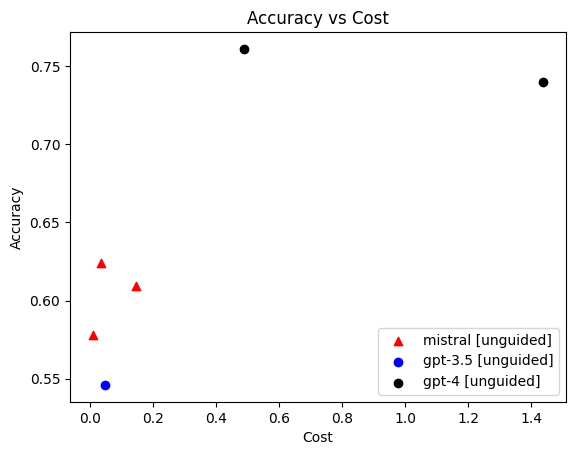

In [39]:
#plot accuracy vs cost
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.scatter(df[df['llm'] == 'mistral']['cost'],
           df[df['llm'] == 'mistral']['accuracy'], 
           marker='^', c='red', label='mistral [unguided]')
ax.scatter(df[df['llm'] == 'gpt-3.5']['cost'],
           df[df['llm'] == 'gpt-3.5']['accuracy'], 
           marker='o', c='blue', label='gpt-3.5 [unguided]')
ax.scatter(df[df['llm'] == 'gpt-4']['cost'],
           df[df['llm'] == 'gpt-4']['accuracy'], 
           marker='o', c='black', label='gpt-4 [unguided]')


plt.legend()

plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Cost')
plt.show()

In [40]:
fig.savefig('../reports/figures/sarcasm_accuracy_vs_cost_mistral_openai.png', dpi=300, bbox_inches='tight')